# Assignment1 Sentiment Analysis

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from functools import reduce
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
!pip install wordcloud
from wordcloud import WordCloud

import html
import re
from scipy import stats
import random
random.seed()

!pip install nltk
import nltk
from nltk.tokenize import RegexpTokenizer

###  Import original data and stop words

In [2]:
generic_tweets = pd.read_csv('generic_tweets.txt')
airline_tweets = pd.read_csv('US_airline_tweets.csv')
print("Shape of generic_tweets:",generic_tweets.shape)
print("Shape of airline_tweets:",airline_tweets.shape)

with open('stop_words.txt','r') as f:
    stop_words = f.read().split('\n')

Shape of generic_tweets: (200000, 6)
Shape of airline_tweets: (11541, 6)


In [3]:
generic_tweets.head(3)

,class,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...


In [4]:
airline_tweets.head(3)

,id,sentiment,negative_reason,user,retweet_count,text
0,5.703010e+17,positive,NaN,jnardino,0,@VirginAmerica plus you've added commercials t...
1,5.703010e+17,negative,Bad Flight,jnardino,0,@VirginAmerica it's really aggressive to blast...
2,5.703010e+17,negative,Can't Tell,jnardino,0,@VirginAmerica and it's a really big bad thing...


## Q1 Data Cleaning
Create a data cleaner to perform the data cleaning procedure in sequence:

- Encode according to ASCII
- Remove html tags and attributes
- Remove URLs
- Change to lower cases
- Collect @tag message to detect airline
- Tokenize word stream
- Remove stop words
- Remove all non-alphanumerical charactors

In [5]:
class DataCleaner(object):
    def __init__(self,stop_words=[""], remove_steps = []):
        super().__init__()
        self.hashtags = str()
        self.remove_steps = remove_steps
        self.stop_words = stop_words
        self.procedures = [getattr(self,procedure) for procedure in \
                        [step for step in sorted(dir(self)) if step.startswith("step_")]]
        # remove some procedures according to users' needs
        for i in sorted(self.remove_steps,reverse=True):
                self.procedures.pop(i-1)

    #use reduce to sequentially clean the raw data, equivelent to funcN(...func2(func1(data)))
    def clean(self, data):
            return reduce(lambda data,func:func(data),[data]+self.procedures), self.hashtags

    # Html character codes (i.e., &...;) are replaced with an ASCII equivalent.
    def step_01_to_ascii(self, data):
        return html.unescape(data)

    # Remove html tags and attributes in form of <...>
    def step_02_remove_html_tag(self, data):
        return re.sub(r"\s*<.*?>",'', data)

    # Remove url in form of (http or https://)address.domain(/file)
    def step_03_remove_url(self, data):
        return re.sub(r'\s*(?:https?:\/\/)?[\w.-]+(?:\.[\w.-]+)+[\w\-._~:/?#[\]@!\$&\'\(\)\*\+,;=.]+','',data)

    # Change all characters in the text to lowercase.
    def step_04_to_lower(self, data):
        return data.lower()

    # Collect @ tag message
    def step_05_hashtag_collection(self,data):
        self.hashtags = ' '.join(re.findall(r'(?<=@)[^\s]+\s?',data))
        return re.sub(r'@.*?\s','',data)

    # Tokenize the word stream
    def step_06_tokenization(self,data):
        tokenizer = RegexpTokenizer(r'\w+')
        words_list = tokenizer.tokenize(data)
        return ' '.join(words_list)

    # Remove stop words
    def step_07_remove_stop_words(self,data):
        words = data.split()
        new_data = [word for word in words if word not in self.stop_words]
        return ' '.join(new_data) # clean up empty charactor

    # Remove non alphanumeric characters except space
    def step_08_remove_nonAlphaNumerical(self,data):
        return re.sub(r'[^\s\w]+','',data)

#### Clean generic_tweets

In [6]:
geneCleaner = DataCleaner(stop_words,[5])
generic_tweets['cleaned_text'],_ = np.vectorize(geneCleaner.clean)(generic_tweets['text'])
generic_tweets.head(3)

,class,id,date,query,user,text,cleaned_text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",switchfoot awww bummer shoulda david carr thir...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,upset t update facebook texting cry result sch...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,kenichan dived times ball managed save 50 rest...


#### Clean airline_tweets

In [7]:
airCleaner = DataCleaner(stop_words)
airline_tweets['cleaned_text'],airline_tweets['@_tags'] = np.vectorize(airCleaner.clean)(airline_tweets['text'])
airline_tweets.head(3)

,id,sentiment,negative_reason,user,retweet_count,text,cleaned_text,@_tags
0,5.703010e+17,positive,NaN,jnardino,0,@VirginAmerica plus you've added commercials t...,ve commercials tacky,virginamerica
1,5.703010e+17,negative,Bad Flight,jnardino,0,@VirginAmerica it's really aggressive to blast...,aggressive blast obnoxious entertainment guest...,virginamerica
2,5.703010e+17,negative,Can't Tell,jnardino,0,@VirginAmerica and it's a really big bad thing...,big bad thing,virginamerica


## Q2 Exploratory analysis

When cleaning data in Q1, we created "@_tag" column which contains word in tweetertext that starts with '@'. This piece of information contains most of the airline information. 

We check @_tags and find that there are a total of 7 airlines in our dataset. Also there is one tweeter that doesn't indicate airline.

We use the function "LabelAir" to get the airline and do exploratory analysis.

In [8]:
def LabelAir(tags,text):
    airlines = ['americanair','usairways','united','deltaassist',\
                'jetblue','southwestair','virginamerica']
    for airline in airlines:
        if tags.find(airline)>=0:
            return airline
    for airline in airlines:
        if text.lower().find(airline)>=0:
            return airline
    return "Unknown"

airline_tweets['airline'] = [LabelAir(a,b) for a, b in zip(airline_tweets['@_tags'],airline_tweets['text'])]
# LabelAir(airline_tweets.iloc[6184]['@_tags'],airline_tweets.iloc[6184]['text'])
airline_tweets.head(3)

,id,sentiment,negative_reason,user,retweet_count,text,cleaned_text,@_tags,airline
0,5.703010e+17,positive,NaN,jnardino,0,@VirginAmerica plus you've added commercials t...,ve commercials tacky,virginamerica,virginamerica
1,5.703010e+17,negative,Bad Flight,jnardino,0,@VirginAmerica it's really aggressive to blast...,aggressive blast obnoxious entertainment guest...,virginamerica,virginamerica
2,5.703010e+17,negative,Can't Tell,jnardino,0,@VirginAmerica and it's a really big bad thing...,big bad thing,virginamerica,virginamerica


In [9]:
airline_tweets['airline'].value_counts()

united           3116
americanair      2453
usairways        2417
southwestair     1733
jetblue          1490
virginamerica     329
deltaassist         2
Unknown             1
Name: airline, dtype: int64

#### Draw a bar to show the distribution of the US airlines of the tweets

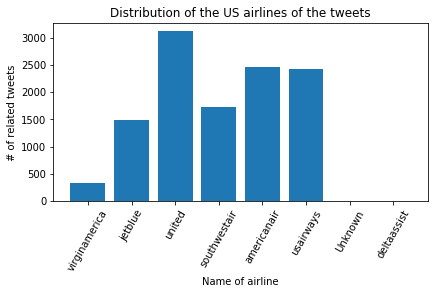

In [10]:
# plot a histogram
x = Counter(airline_tweets['airline'])
l = range(len(x.keys()))
plt.bar(l, x.values())
plt.xticks(l, x.keys(),rotation=60)
plt.xlabel('Name of airline')
plt.ylabel('# of related tweets')
plt.title('Distribution of the US airlines of the tweets')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

The distribution results above show the class imbalance of Airlines usage. The most tweeters are from United Airline while very little from VirginAmerica and DeltaAssist. 

#### We draw the WordCloud to show the public's positive voice in generic_tweeting. To make the words more readable, we eliminate some of the steps when cleaning data.

In [11]:
readerCleaner = DataCleaner(stop_words,[5,6])
generic_positive_voice,_ = np.vectorize(readerCleaner.clean)(generic_tweets[generic_tweets['class']==4]['text'])

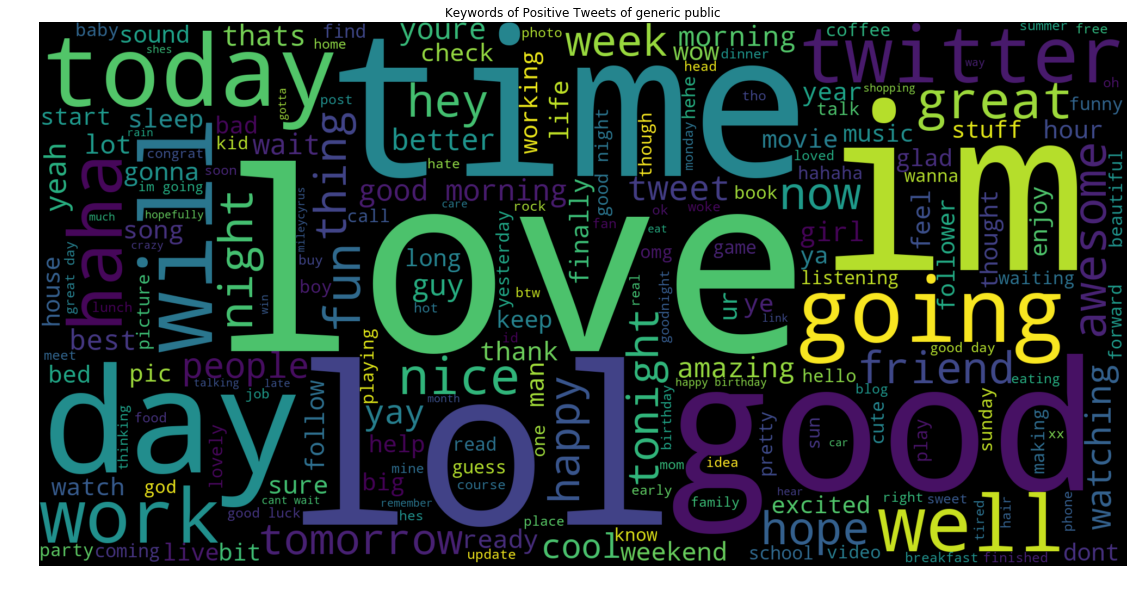

In [12]:
generic_positive = " ".join([j for i in generic_positive_voice for j in i.split()])
generic_positive_wordcloud = WordCloud(width = 2000, height = 1000).generate(generic_positive)

plt.figure(figsize=(20,10))
plt.imshow(generic_positive_wordcloud, interpolation='bilinear')
plt.title('Keywords of Positive Tweets of generic public')
plt.axis("off")
plt.show()

From the word cloud of population's positive voice, we can see that positive tweeters have some key words like "good","love","haha". And some other key words include "tomorrow", "going", "will". It seems that positive tweeters show people's hope and plan about future.

#### As comparison, we also draw the WordCloud to show the public's keywords of negative voice in airline_tweets. To make the words more readable, we eliminate some of the steps when cleaning data.

In [13]:
airline_negative_voice,_ = np.vectorize(readerCleaner.clean)(airline_tweets[airline_tweets['sentiment']=='negative']['text'])

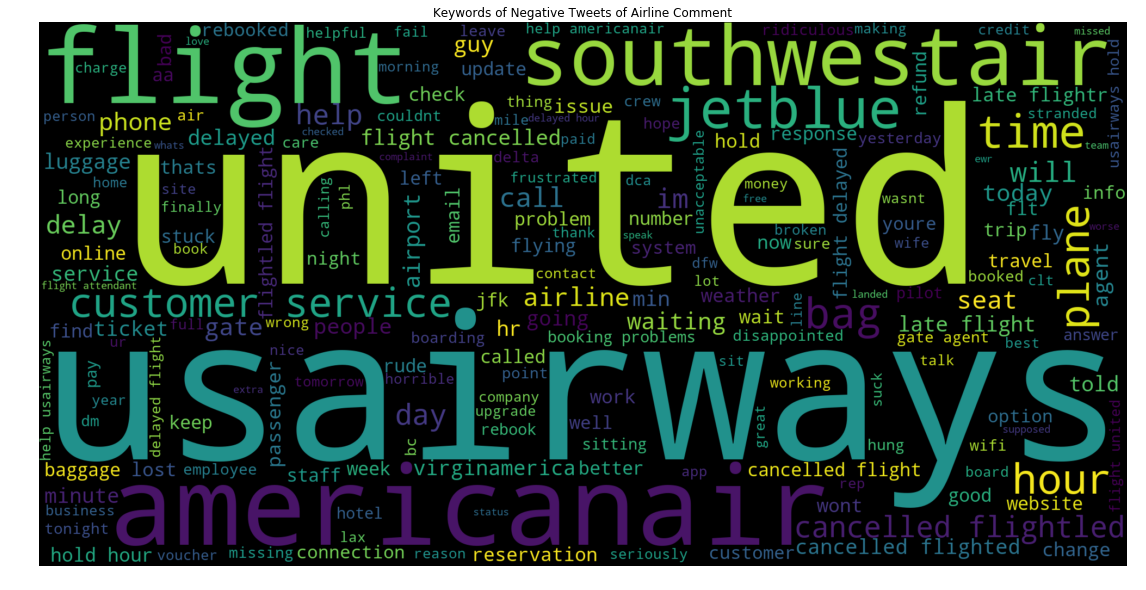

In [14]:
airline_negative = " ".join([j for i in airline_negative_voice for j in i.split()])
airline_negative_wordcloud = WordCloud(width = 2000, height = 1000).generate(airline_negative)

plt.figure(figsize=(20,10))
plt.imshow(airline_negative_wordcloud, interpolation='bilinear')
plt.title('Keywords of Negative Tweets of Airline Comment')
plt.axis("off")
plt.show()

From the word cloud of population's negative voice of airlines, we can see that many negative tweeters have some key words like "usairways", "americanair" and "united", which are three airlines. This is easy to understand because they are three airlines with the most tweeters. We can detect some of the reasons of negative comments, which include "service", "cancelled", "late flight" and "delayed".

## Q2-Bonus

We also draw the bar to show ratio of public's sentiment in each airlines. Here we only consider the most six popular airlines.

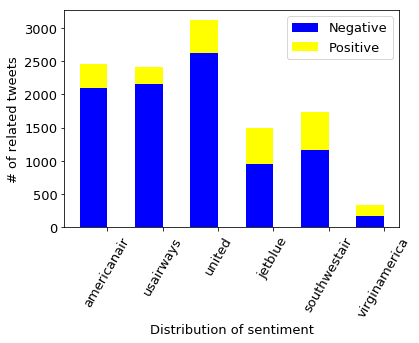

In [15]:
def ratio_2d(dataFrame,class1,attr1,label2,attr2):
    num = []
    nega = []
    for i in class1:
        num.append(dataFrame[dataFrame[attr1]==i].iloc[:,0].count())
        nega.append(dataFrame[(dataFrame[attr1]==i) & (dataFrame[attr2]==label2)].iloc[:,0].count())
    num = np.array(num)
    nega = np.array(nega)
    ratio = nega / num
    return num,ratio

airlines = ['americanair','usairways','united','jetblue','southwestair','virginamerica']
num,ratio = ratio_2d(airline_tweets,airlines,'airline','negative','sentiment')

negative = num * ratio
positive = num * (1-ratio)

plt.rc('font', family='DejaVu Sans', size=13)
width=0.5
idx = np.arange(len(airlines))
plt.bar(idx, negative, width, color='blue', label='Negative')
plt.bar(idx, positive, width, bottom=negative, color='yellow', label='Positive')
plt.xlabel('Distribution of sentiment')
plt.ylabel('# of related tweets')
plt.xticks(idx+width/2, airlines, rotation=60)
plt.legend()

From the graph above, we can see that although airline virginAmerica doesn't have the most tweeters, it's ratio of positive feedback is relatively higher. Comparatively, USAirways, United and Americanair have high popularity but their ratios of negative feedback are very high.

## Q3 Model Preparation
Prepare the data for model training and testing in sequense:

- Create features based on the frequency of each words with "tf-idf" method
- Split data for 70% training use and 30% test use

In [16]:
'''
Create a class "DataGenerator" that can be used to generate training and testing data from original DataFrame.
    For choosing features, I provide three methods:"tf-idf"/"most_common_bi"/"most_common_freq", 
        where "tf-idf"takes all the terms that appear in data into account,
        and  "most_common_bi" only takes the most N common words into account and does binary encoding on them,
        and  "most_common_freq" only takes the most N common words into account and does frequency encoding on them.
    For spliting dataset, I provide one method which enables you to determine if you want validation set.
'''

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

class DataGenerator(object):
    def __init__(self,dataFrame):
        super().__init__()
        self.dataFrame = dataFrame

    def generate(self,feature_column,label_column,method="tf-idf",top=1000):
        if method=="tf-idf":
            return self._generate_tf_idf(feature_column,label_column)
        elif method=="most_common_bi":
            return self._generate_most_bi(feature_column,label_column,top)
        elif method=="most_common_freq":
            return self._generate_most_freq(feature_column,label_column,top)
        else:
            print("Please check your data generation method.")
            return None

    def _generate_tf_idf(self,feature_column,label_column):
        # transform all text data into TF-IDF features
        tfidf_vector = TfidfVectorizer(stop_words='english')
        X = tfidf_vector.fit_transform(self.dataFrame[feature_column])
        Y = self.dataFrame[label_column]
        return X,Y,tfidf_vector

    def _generate_most_bi(self,feature_column,label_column,top=500):
        news_cnt = self.corpus_count_words(self.dataFrame[feature_column])
        # Feature selection: we choose the word with high term frequency in whole text collections
        word_list = [word for (word, freq) in news_cnt.most_common(top)]
        df_rows = []
        for text in self.dataFrame[feature_column]:
            text_words_counter = self.corpus_count_words([text])
            df_rows.append([1 if text_words_counter[word]>0 else 0 for word in word_list])
        
        X = pd.DataFrame(df_rows, columns = word_list)
        Y = self.dataFrame[label_column]
        return X, Y, word_list

    def _generate_most_freq(self,feature_column,label_column,top=500):
        news_cnt = self.corpus_count_words(self.dataFrame[feature_column])
        # Feature selection: we choose the word with high term frequency in whole text collections
        word_list = [word for (word, freq) in news_cnt.most_common(top)]
        df_rows = []
        for text in self.dataFrame[feature_column]:
            text_words_counter = self.corpus_count_words([text])
            df_rows.append([text_words_counter[word] if text_words_counter[word]>0 else 0 for word in word_list])

        X = pd.DataFrame(df_rows, columns = word_list)
        Y = self.dataFrame[label_column]
        return X, Y, word_list

    def corpus_count_words(self,dataSeries):
        stop = stopwords.words('english')
        wordnet_lemmatizer = WordNetLemmatizer()
        word_counter = Counter()
        for text in dataSeries:
            words = [wordnet_lemmatizer.lemmatize(i) for i in text.split() if i not in stop]
            word_counter.update(words)
        return word_counter

    def split_data(self,X,Y,percent=[0.7,0.3],random_state=42):
        if len(percent) == 2:
            X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=percent[1], random_state=random_state)
            return X_train,X_test,y_train,y_test
        elif len(percent) == 3:
            print("You also create validation set...")
            X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=percent[1], random_state=random_state)
            X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=percent[2]/(1-percent[1]), random_state=random_state)
            return X_train,X_valid,X_test,y_train,y_valid,y_test
        else:
            print("Please check you percent.\n")
            return None

[nltk_data] Downloading package stopwords to /home/hanwen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/hanwen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [17]:
generic_tweets['class'] = [1 if row['class']==4 else 0 for index,row in generic_tweets.iterrows()]

In [18]:
geneGenerator = DataGenerator(generic_tweets)

In [19]:
generic_X_tf, generic_Y_tf, feature_list_tf = geneGenerator.generate("cleaned_text","class","tf-idf")
generic_X_train_tf,generic_X_test_tf,generic_y_train_tf,generic_y_test_tf = geneGenerator.split_data(generic_X_tf,generic_Y_tf)

## Q4 Model implementation

Create a classifiers class to develop a set of classifiers (currently Logistic Regression, Multinomial Naive Bayes and Bernoulli Naive Bayes). We could constructe those classifiers by training only with default hyper-parameters only or training with hyper-parameters tuning. 

In [20]:
from collections import OrderedDict

from sklearn.naive_bayes import BernoulliNB as bnb
from sklearn.linear_model import LogisticRegression as lr
from sklearn.naive_bayes import MultinomialNB as mnb

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve, auc

class Classifier(object):
    def __init__(self,train_data,train_labels):
        super().__init__()
        self.train_data = train_data
        self.train_labels = train_labels
        self.models=OrderedDict([('LogisticRegression',[lr(C=1.1),dict(C=np.arange(0.1,3,0.2))]),\
                            ('MultinomialNB',[mnb(alpha=7.1),dict(alpha=np.arange(0.1,10,1))]),\
                            ('BernoulliNB',[bnb(alpha=3.1),dict(alpha=np.arange(0.1,10,1))])])
        #1.1 and 2.70
    def train_model(self,model_name,ifhyper_tune=False,hyper_paras=""):
        model = self.models[model_name][0]
        if ifhyper_tune:
            if not hyper_paras:
                hyper_paras = self.models[model_name][1]
            # Grid search method for hyper-parameter tuning in which we use 5-fold cross validation
            if hyper_paras:
                grid = GridSearchCV(model, hyper_paras, cv=5, scoring='accuracy', n_jobs=-1) 

                grid.fit(self.train_data, self.train_labels)
                print('The best score of model {} through 5-cross validation is {}, with the best hyper-parameter {}\n'\
                    .format(model_name, grid.best_score_, grid.best_params_))

                # Best model
                best_model = grid.best_estimator_
            else:
                best_model = model.fit(self.train_data,self.train_labels)
        else:
            best_model = model.fit(self.train_data,self.train_labels)
        train_pred = best_model.predict(self.train_data)
        print('Train accuracy of {} model is {}\n'.format(model_name,accuracy_score(self.train_labels,train_pred)))
        return best_model, accuracy_score(self.train_labels,train_pred)

    def test_model(self,best_model,test_data,test_labels,if_report=False,model_name=""):
        test_pred = best_model.predict(test_data)
        
        cm = confusion_matrix(test_labels, test_pred)
        #test accuracy
        print('Model {} has test accuracy {}\n'.format(model_name, accuracy_score(test_labels,test_pred)))
        #test result report
        if if_report:
            print('Test result report:\n\n', classification_report(test_labels, test_pred),'\n')
            if len(set(test_labels))==2:
                test_score = best_model.predict_proba(test_data)
                print('ROC plot and corresponding AUC:\n')
                self.plot_roc(test_labels,test_score)
            elif len(set(test_labels))>2:
                self.plot_confusion_matrix(cm)
        return accuracy_score(test_labels,test_pred),cm

    def plot_roc(self,true, score):
        preds = score[:,1]
        fpr, tpr, threshold = roc_curve(true, preds)
        roc_auc = auc(fpr, tpr)
        plt.title('Receiver Operating Characteristic')
        plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')

    def plot_confusion_matrix(self,cm):
        # plot the confusion matrix
        plt.figure(figsize=(10,10))
        plt.matshow(cm, fignum=1)

        # add labels for all targets
        num_targets = cm.shape[0]
        plt.xticks(list(range(num_targets+1)))
        plt.yticks(list(range(num_targets+1)))

### Q4.1 TASK 1 
#### Train a logistic regression model on the training data and obtain the result below:

In [21]:
geneClassifier_tf = Classifier(generic_X_train_tf,generic_y_train_tf)
generic_tf_lr, _ = geneClassifier_tf.train_model('LogisticRegression')

/home/hanwen/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train accuracy of LogisticRegression model is 0.8266571428571429



#### Test the obtained model using test data and obtain the result below:

Model  has test accuracy 0.7404833333333334

Test result report:

               precision    recall  f1-score   support

           0       0.76      0.70      0.73     29851
           1       0.72      0.78      0.75     30149

   micro avg       0.74      0.74      0.74     60000
   macro avg       0.74      0.74      0.74     60000
weighted avg       0.74      0.74      0.74     60000
 

ROC plot and corresponding AUC:



(0.7404833333333334, array([[20942,  8909],
        [ 6662, 23487]]))

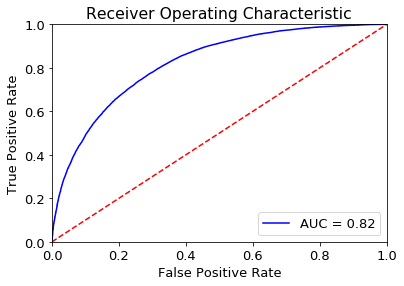

In [22]:
geneClassifier_tf.test_model(generic_tf_lr,generic_X_test_tf,generic_y_test_tf,True)

#### Evaluate the model 1 on the US airline data and get the result below:

In [23]:
airline_tweets['class'] = [1 if row['sentiment']=='positive' else 0 for index,row in airline_tweets.iterrows()]

Model  has test accuracy 0.7536608612771857

Test result report:

               precision    recall  f1-score   support

           0       0.93      0.74      0.83      9178
           1       0.44      0.79      0.57      2363

   micro avg       0.75      0.75      0.75     11541
   macro avg       0.69      0.77      0.70     11541
weighted avg       0.83      0.75      0.77     11541
 

ROC plot and corresponding AUC:



(0.7536608612771857, array([[6835, 2343],
        [ 500, 1863]]))

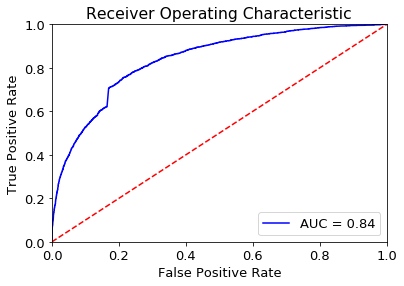

In [24]:
airline_X_tf = feature_list_tf.transform(airline_tweets['cleaned_text'])
geneClassifier_tf.test_model(generic_tf_lr,airline_X_tf,airline_tweets['class'],True)

From the result above, you can see that the LogisticRegression model trained on generic tweeters performs good on US_airline_tweeters and gets the test accuracy 75.4%. The AUC value is 0.84.

### Q4.2 TASK 2
#### Split the negative US airline tweets into training data (70%) and test data (30%). Train a multi-class logistic regression model to predict the reason for the negative tweets. 

In [25]:
neg_airline_tweets = airline_tweets[airline_tweets['sentiment']=='negative']
all_reasons = set(neg_airline_tweets['negative_reason'])
print(all_reasons)

{'Cancelled Flight', 'Damaged Luggage', 'Late Flight', 'Bad Flight', 'Flight Attendant Complaints', 'Customer Service Issue', "Can't Tell", 'Lost Luggage', 'Flight Booking Problems', 'longlines'}


From the above result, we can see there are 10 different reasons. "Damaged Luggage" and "Lost Luggage" are all reasons about luggage, so we merge them into same reason "Luggage Issue". The reason "Bad Flight" is a vague description which cannot tell an explicit reason of complaint, so we mere them into "Can't Tell".

In [26]:
neg_airline_tweets_new = neg_airline_tweets.copy()
neg_airline_tweets_new['negative_reason']=np.where(neg_airline_tweets_new['negative_reason'] =='Damaged Luggage', 'Luggage Issue', neg_airline_tweets_new['negative_reason'])
neg_airline_tweets_new['negative_reason']=np.where(neg_airline_tweets_new['negative_reason'] =='Lost Luggage', 'Luggage Issue', neg_airline_tweets_new['negative_reason'])
neg_airline_tweets_new['negative_reason']=np.where(neg_airline_tweets_new['negative_reason'] =='Bad Flight', "Can't Tell", neg_airline_tweets_new['negative_reason'])

In [27]:
# After reducing the categories of negative reasons, we have a total of 8 reasons for negative sentiment. 
# We map different reasons to different labe.

def LabelReason(data):
    all_reason = {"Can't Tell":0,'Cancelled Flight':1,'Customer Service Issue':2,'Luggage Issue':3,\
                  'Flight Attendant Complaints':4,'Flight Booking Problems':5,'Late Flight':6,'longlines':7}
    return all_reason[data]
# neg_airline_tweets_new = neg_airline_tweets_new.copy()
neg_airline_tweets_new.loc[:,'class'] = np.vectorize(LabelReason)(neg_airline_tweets_new['negative_reason'])
neg_airline_tweets_new.head()

,id,sentiment,negative_reason,user,retweet_count,text,cleaned_text,@_tags,airline,class
1,5.703010e+17,negative,Can't Tell,jnardino,0,@VirginAmerica it's really aggressive to blast...,aggressive blast obnoxious entertainment guest...,virginamerica,virginamerica,0
2,5.703010e+17,negative,Can't Tell,jnardino,0,@VirginAmerica and it's a really big bad thing...,big bad thing,virginamerica,virginamerica,0
3,5.703010e+17,negative,Can't Tell,jnardino,0,@VirginAmerica seriously would pay $30 a fligh...,seriously pay 30 flight seats didn t playing b...,virginamerica,virginamerica,0
11,5.702820e+17,negative,Late Flight,smartwatermelon,0,@VirginAmerica SFO-PDX schedule is still MIA.,sfo pdx schedule mia,virginamerica,virginamerica,6
13,5.702770e+17,negative,Can't Tell,heatherovieda,0,@VirginAmerica I flew from NYC to SFO last we...,flew nyc sfo week couldn t fully sit seat larg...,virginamerica,virginamerica,0


In [28]:
negaGenerator = DataGenerator(neg_airline_tweets_new)

In [29]:
neg_X_tf, neg_Y_tf,neg_feature_tf = negaGenerator.generate("cleaned_text","class","tf-idf")
neg_X_train_tf,neg_X_test_tf,neg_y_train_tf,neg_y_test_tf = negaGenerator.split_data(neg_X_tf,neg_Y_tf)

In [30]:
negClassifier_tf = Classifier(neg_X_train_tf,neg_y_train_tf)
neg_tf_lr,_ = negClassifier_tf.train_model('LogisticRegression')

Train accuracy of LogisticRegression model is 0.773038605230386



/home/hanwen/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/hanwen/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [31]:
_, neg_cm_tf_lr = negClassifier_tf.test_model(neg_tf_lr,neg_X_test_tf,neg_y_test_tf)

Model  has test accuracy 0.6336238198983297



## Q5 Answer the research questions

In [32]:
# airline_X_tf = feature_list_tf.transform(airline_tweets['cleaned_text'])
airline_tweets['pred_tf_lr'] = generic_tf_lr.predict(airline_X_tf)

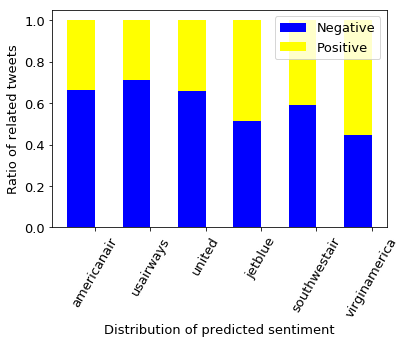

In [33]:
airlines = ['americanair','usairways','united','jetblue','southwestair','virginamerica']
num,ratio = ratio_2d(airline_tweets,airlines,'airline',0,'pred_tf_lr')

negative = ratio
positive = 1-ratio

plt.rc('font', family='DejaVu Sans', size=13)
width=0.5
idx = np.arange(len(airlines))
a = plt.bar(idx, negative, width, color='blue', label='Negative')
b = plt.bar(idx, positive, width, bottom=negative, color='yellow', label='Positive')

plt.xlabel('Distribution of predicted sentiment')
plt.ylabel('Ratio of related tweets')
plt.xticks(idx+width/2, airlines, rotation=60)
plt.legend()

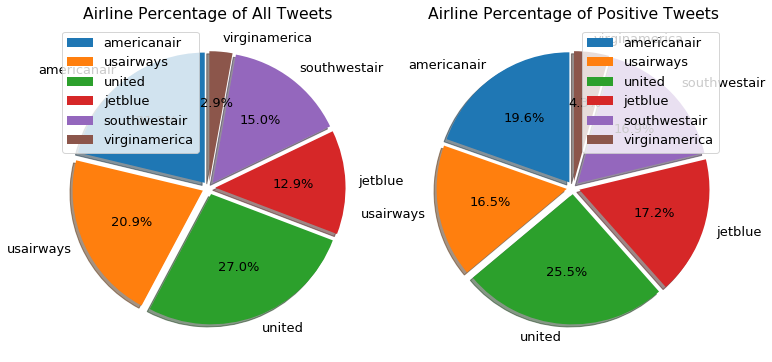

In [34]:
# Plot of Party Percentage on Positive Tweets
positive_num = num * (1-ratio)
plt.figure(figsize=(12,6))

fig1 = plt.subplot(121)
plt.title('Airline Percentage of All Tweets')
plt.pie(num,labels=airlines,explode=(0.05, 0.05,0.05,0.05,0.05,0.05),\
       labeldistance = 1.1,autopct = '%3.1f%%',shadow = True, startangle = 90,pctdistance = 0.6)
plt.axis('equal')
plt.legend()

fig2 = plt.subplot(122)
plt.title('Airline Percentage of Positive Tweets')
plt.pie(positive_num,labels=airlines,explode=(0.05, 0.05,0.05,0.05,0.05,0.05),\
       labeldistance = 1.1,autopct = '%3.1f%%',shadow = True, startangle = 90,pctdistance = 0.6)
plt.axis('equal')
plt.legend()
plt.show()

#### Q5.1 Based on the outputs of your first model, describe the results of the analysis and discuss your interpretation of the results. Explain how each airline is viewed in the public eye based on the sentiment value. 

Answer:
Our discussion focuses on the most 6 popular airlines in tweeter. Based on the graph "Airline Percentage of All Tweets", the most popular airline that mentioned in tweets file is United, followed by Americanair and Usairways.
Based on the graph "Airline Percentage of Positive Tweets", we can see among the positive Tweets, United Airline holds the majority portion, and Virginamerica holds the minority portion.

However, since different airlines has different number of tweets, we shouldn't solely analysize the absolute number of positive tweets. According to the graph "Distribution of Predicted Tweets", we can see virginamerica and jetblue have larger portion of positive tweets, while United, Americanair and USairways have larger portion of negative tweets.

In [35]:
neg_airline_tweets_new['pred_tf_lr'] = neg_tf_lr.predict(neg_X_tf)

[[330   3 135   9   2   2  37   0]
 [ 29 181  34   2   0   2  13   0]
 [103  26 686  11   6  10  33   0]
 [ 34   0  31 161   1   0  19   0]
 [ 38   0  60   5  17   0  17   0]
 [ 26   5  79   2   0  25   8   0]
 [ 90   8  61  12   0   2 344   0]
 [ 10   2  20   4   1   0  17   1]]


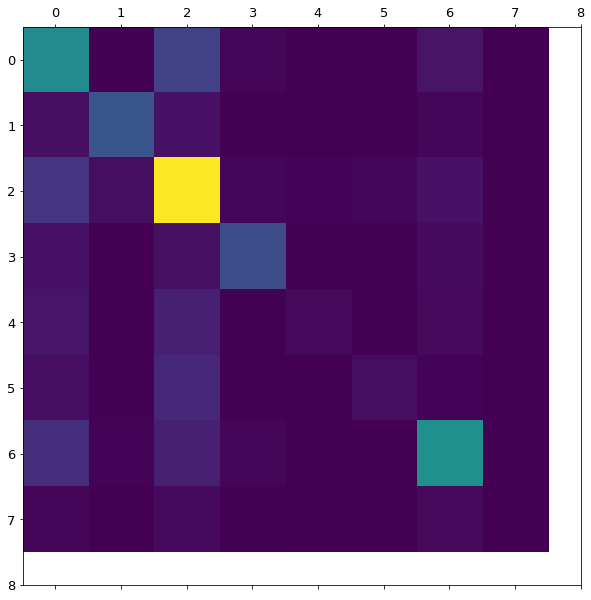

In [36]:
print(neg_cm_tf_lr)
negClassifier_tf.plot_confusion_matrix(neg_cm_tf_lr)

In [37]:
# confuse_0_2 is the tweets which belong to "Can't Tell" but are classified as "Customer Service Issue"
confuse_0_2 = neg_airline_tweets_new[(neg_airline_tweets_new['class']==0) & (neg_airline_tweets_new['pred_tf_lr']==2)]
print(confuse_0_2['text'][0:4])

21     @VirginAmerica What happened 2 ur vegan food o...
156    @VirginAmerica  how are you gonna have a deal ...
372    @united When will email address/username sign-...
471                       @united YOU GUYS ARE HORRIBLE.
Name: text, dtype: object


In [38]:
# confuse_2_0 is the tweets which belong to "Customer Service Issue" but are classified as "Can't Tell"
confuse_2_0 = neg_airline_tweets_new[(neg_airline_tweets_new['class']==2) & (neg_airline_tweets_new['pred_tf_lr']==0)]
print(confuse_2_0['text'][0:4])

19     @VirginAmerica you guys messed up my seating.....
189    @VirginAmerica Boo for a not refunding a seat ...
217    @virginAmerica Other carriers are less than ha...
392    @united as a 1k, I'm always hoping for improve...
Name: text, dtype: object


#### Q5.2 Based on the second model, provide a few reasons why your model failed to predict the correct negative reasons. Back up your reasoning with examples from the test sets. 

Answer: Based on the performance of second model, we plotted confusion matrix of eight reasons above, where {"Can't Tell":0,'Cancelled Flight':1,'Customer Service Issue':2,'Luggage Issue':3,'Flight Attendant Complaints':4,'Flight Booking Problems':5,'Late Flight':6,'longlines':7}.
We can see that class0(Can't Tell) is easily confused with class2(Customer Service Issue). The reason may be that the complaints about this two classes have some similar components.

We respectively list four examples of wrongly classified tweets. As you can see from the examples, No.21 complains about food, which can be classified as "Can't Tell" or "Customer Service Issue". No.471 and No.392 don't clarify the reasons, which may be due to "Customer Service Issue".

#### For both models, suggest one way you can improve the accuracy of your models?

Answer: There are several ways that may improve the accuracy of the model. 
- Improve the collected data. Give more accuracy and precise choices to the customers. Don't mess up the choices.
- Feature Construction. Use more comprehensive feature construction methods (eg. word2vec, GloVe) that take into account more than word frequency, like phrase etc.
- Feature Selection. Do feature selection on constructed features to choose the features that are more informative to the labels.
- Hyperparameter tuning on models. 

## BONUS PART

## Q3-Bonus  

Instead of using "tf-idf" as the feature generation method, we use N-most-common words as the feature. And we try binary encoding and frequency encoding on chosen terms. 

##### As this process takes much time and much memory space, we commented them and just showed the result.

In [39]:
'''
# Using MOST-COMMON-BINARY features with LogisticRegression

generic_X_mb, generic_Y_mb, feature_list_mb = geneGenerator.generate("cleaned_text","class","most_common_bi")
generic_X_train_mb,generic_X_test_mb,generic_y_train_mb,generic_y_test_mb = geneGenerator.split_data(generic_X_mb,generic_Y_mb)
geneClassifier_mb = Classifier(generic_X_train_mb,generic_y_train_mb)
print("TRAIN PERFORMANCE:")
generic_mb_lr, _ = geneClassifier_mb.train_model('LogisticRegression')
print("TEST PERFORMANCE:")
geneClassifier_mb.test_model(generic_mb_lr,generic_X_test_mb,generic_y_test_mb)
'''

'\n# Using MOST-COMMON-BINARY features with LogisticRegression\n\ngeneric_X_mb, generic_Y_mb, feature_list_mb = geneGenerator.generate("cleaned_text","class","most_common_bi")\ngeneric_X_train_mb,generic_X_test_mb,generic_y_train_mb,generic_y_test_mb = geneGenerator.split_data(generic_X_mb,generic_Y_mb)\ngeneClassifier_mb = Classifier(generic_X_train_mb,generic_y_train_mb)\nprint("TRAIN PERFORMANCE:")\ngeneric_mb_lr, _ = geneClassifier_mb.train_model(\'LogisticRegression\')\nprint("TEST PERFORMANCE:")\ngeneClassifier_mb.test_model(generic_mb_lr,generic_X_test_mb,generic_y_test_mb)\n'

TRAIN PERFORMANCE:
Train accuracy of LogisticRegression model is 0.7146214285714285

TEST PERFORMANCE:
Model  has test accuracy 0.70605

In [40]:
'''
# Using MOST-COMMON-FREQUENCY features with LogisticRegression

generic_X_mf, generic_Y_mf, feature_list_mf = geneGenerator.generate("cleaned_text","class","most_common_freq")
generic_X_train_mf,generic_X_test_mf,generic_y_train_mf,generic_y_test_mf = geneGenerator.split_data(generic_X_mf,generic_Y_mf)
geneClassifier_mf = Classifier(generic_X_train_mf,generic_y_train_mf)
print("TRAIN PERFORMANCE:")
generic_mf_lr, _ = geneClassifier_mf.train_model('LogisticRegression')
print("TEST PERFORMANCE:")
geneClassifier_mf.test_model(generic_mf_lr,generic_X_test_mf,generic_y_test_mf)
'''

'\n# Using MOST-COMMON-FREQUENCY features with LogisticRegression\n\ngeneric_X_mf, generic_Y_mf, feature_list_mf = geneGenerator.generate("cleaned_text","class","most_common_freq")\ngeneric_X_train_mf,generic_X_test_mf,generic_y_train_mf,generic_y_test_mf = geneGenerator.split_data(generic_X_mf,generic_Y_mf)\ngeneClassifier_mf = Classifier(generic_X_train_mf,generic_y_train_mf)\nprint("TRAIN PERFORMANCE:")\ngeneric_mf_lr, _ = geneClassifier_mf.train_model(\'LogisticRegression\')\nprint("TEST PERFORMANCE:")\ngeneClassifier_mf.test_model(generic_mf_lr,generic_X_test_mf,generic_y_test_mf)\n'

TRAIN PERFORMANCE:
Train accuracy of LogisticRegression model is 0.7145428571428571

TEST PERFORMANCE:
Model  has test accuracy 0.7059666666666666

For task 1, now we obtained the training and testing accuracy of three type of features with LogisticRegression:

|  Feature        |train_acc|test_acc|
|---              |---      |---   | 
|tf-idf           |0.8267   |0.7405|
|most_common_bi   |0.7146   |0.7060|
|most_common_freq |0.7145   |0.7059|

From the test accuracy, we can conclude that tf-idf are the best among them.

### Q4-Bonus 
- Explore alternative classification methods and compare their performance to that of the logistic regression model.
- Improve the performance of your model by tuning models' hyperparameters.
- Respectively implement different kinds of classification models on two problems in Q4. 

#### Do hyper-parameter tuning with LogisticRegression model

In [41]:
generic_X, generic_Y, feature_list = geneGenerator.generate("cleaned_text","class")
generic_X_train,generic_X_test,generic_y_train,generic_y_test = geneGenerator.split_data(generic_X,generic_Y)

neg_X, neg_Y,neg_feature = negaGenerator.generate("cleaned_text","class")
neg_X_train,neg_X_test,neg_y_train,neg_y_test = negaGenerator.split_data(neg_X,neg_Y)

In [42]:
geneClassifier = Classifier(generic_X_train,generic_y_train)

In [43]:
print("Training LogisticRegression AND Tuning hyper-parameters for generic_tweeter sentiment classification:\n")

print("TRAIN PERFORMANCE:")
generic_lr, _ = geneClassifier.train_model('LogisticRegression', True)
print("TEST PERFORMANCE:")
geneClassifier.test_model(generic_lr,generic_X_test,generic_y_test)

Training LogisticRegression AND Tuning hyper-parameters for generic_tweeter sentiment classification:

TRAIN PERFORMANCE:


/home/hanwen/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


The best score of model LogisticRegression through 5-cross validation is 0.7416071428571429, with the best hyper-parameter {'C': 0.9000000000000001}

Train accuracy of LogisticRegression model is 0.8191285714285714

TEST PERFORMANCE:
Model  has test accuracy 0.7403



(0.7403, array([[20875,  8976],
        [ 6606, 23543]]))

In [44]:
negClassifier = Classifier(neg_X_train,neg_y_train)

In [45]:
print("Training LogisticRegression AND Tuning hyper-parameters for negative reason classification:\n")

print("TRAIN PERFORMANCE:")
neg_lr,_ = negClassifier.train_model('LogisticRegression',True)
print("TEST PERFORMANCE:")
negClassifier.test_model(neg_lr,neg_X_test,neg_y_test)

Training LogisticRegression AND Tuning hyper-parameters for negative reason classification:

TRAIN PERFORMANCE:
The best score of model LogisticRegression through 5-cross validation is 0.6285803237858032, with the best hyper-parameter {'C': 2.7000000000000006}

Train accuracy of LogisticRegression model is 0.8580323785803238

TEST PERFORMANCE:
Model  has test accuracy 0.6339869281045751



/home/hanwen/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/hanwen/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


(0.6339869281045751, array([[331,   5, 126,   8,   5,   5,  38,   0],
        [ 25, 178,  35,   3,   0,   2,  18,   0],
        [114,  24, 664,  13,   9,  16,  35,   0],
        [ 31,   0,  25, 166,   3,   0,  20,   1],
        [ 37,   0,  51,   5,  29,   1,  14,   0],
        [ 27,   6,  68,   4,   0,  31,   9,   0],
        [ 90,  10,  54,  13,   2,   2, 346,   0],
        [ 11,   2,  17,   4,   1,   1,  18,   1]]))

#### Do hyper-parameter tuning with Multinomial Naive Bayes model

In [46]:
print("Training MultinomialNB AND Tuning hyper-parameters for generic_tweeter sentiment classification:\n")
print("TRAIN PERFORMANCE:")
generic_mnb, _ = geneClassifier.train_model('MultinomialNB',True)
print("TEST PERFORMANCE:")
geneClassifier.test_model(generic_mnb,generic_X_test,generic_y_test)

Training MultinomialNB AND Tuning hyper-parameters for generic_tweeter sentiment classification:

TRAIN PERFORMANCE:
The best score of model MultinomialNB through 5-cross validation is 0.7328642857142857, with the best hyper-parameter {'alpha': 5.1}

Train accuracy of MultinomialNB model is 0.8076785714285715

TEST PERFORMANCE:
Model  has test accuracy 0.7327166666666667



(0.7327166666666667, array([[23522,  6329],
        [ 9708, 20441]]))

In [47]:
print("Training MultinomialNB AND Tuning hyper-parameters for negative reason classification:\n")
print("TRAIN PERFORMANCE:")
neg_mnb,_ = negClassifier.train_model('MultinomialNB',True)
print("TEST PERFORMANCE:")
negClassifier.test_model(neg_mnb,neg_X_test,neg_y_test)

Training MultinomialNB AND Tuning hyper-parameters for negative reason classification:

TRAIN PERFORMANCE:
The best score of model MultinomialNB through 5-cross validation is 0.5375155666251556, with the best hyper-parameter {'alpha': 0.1}

Train accuracy of MultinomialNB model is 0.8595890410958904

TEST PERFORMANCE:
Model  has test accuracy 0.5428467683369644



(0.5428467683369644, array([[219,   7, 177,  22,  10,   7,  76,   0],
        [ 16, 111,  94,   4,   0,   1,  35,   0],
        [ 79,  12, 702,  12,   6,   9,  55,   0],
        [ 22,   6,  79,  96,   3,   2,  38,   0],
        [ 36,   0,  55,   4,  20,   0,  21,   1],
        [ 21,   7,  91,   1,   0,  19,   6,   0],
        [ 59,  18, 101,  10,   0,   1, 328,   0],
        [  3,   1,  24,   4,   1,   1,  21,   0]]))

#### Do hyper-parameter tuning with Bernoulli Naive Bayes model

In [48]:
print("Training BernoulliNB AND Tuning hyper-parameters for generic_tweeter sentiment classification:\n")
print("TRAIN PERFORMANCE:")
generic_bnb, _ = geneClassifier.train_model('BernoulliNB',True)
print("TEST PERFORMANCE:")
geneClassifier.test_model(generic_bnb,generic_X_test,generic_y_test)

Training BernoulliNB AND Tuning hyper-parameters for generic_tweeter sentiment classification:

TRAIN PERFORMANCE:
The best score of model BernoulliNB through 5-cross validation is 0.7332642857142857, with the best hyper-parameter {'alpha': 3.1}

Train accuracy of BernoulliNB model is 0.8185857142857142

TEST PERFORMANCE:
Model  has test accuracy 0.7336



(0.7336, array([[23370,  6481],
        [ 9503, 20646]]))

In [49]:
print("Training BernoulliNB AND Tuning hyper-parameters for negative reason classification:\n")
print("TRAIN PERFORMANCE:")
neg_bnb,_ = negClassifier.train_model('BernoulliNB',True)
print("TEST PERFORMANCE:")
negClassifier.test_model(neg_bnb,neg_X_test,neg_y_test)

Training BernoulliNB AND Tuning hyper-parameters for negative reason classification:

TRAIN PERFORMANCE:
The best score of model BernoulliNB through 5-cross validation is 0.5781444582814446, with the best hyper-parameter {'alpha': 0.1}

Train accuracy of BernoulliNB model is 0.8782689912826899

TEST PERFORMANCE:
Model  has test accuracy 0.5737109658678287



(0.5737109658678287, array([[243,   9, 108,  36,  30,  28,  59,   5],
        [ 10, 184,  33,   8,   0,   4,  22,   0],
        [ 91,  31, 579,  32,  26,  57,  53,   6],
        [ 19,   5,  43, 134,   8,   3,  32,   2],
        [ 39,   0,  29,   8,  40,   2,  18,   1],
        [ 23,   8,  49,   3,   0,  56,   6,   0],
        [ 64,  22,  47,  18,  11,   4, 342,   9],
        [  6,   1,  16,   6,   2,   4,  18,   2]]))

### After hyperparameter tuning, we conclude the result above:

Task1: generic_tweeter sentiment classification

|  Model      |train_acc|test_acc|
|---          |---   |---   | 
|LR           |0.8267|0.7405|
|BernoulliNB  |0.8186|0.7336|
|MultinomialNB|0.7990|0.7326|

Task2: airline_tweeter negative reason classification

|  Model   |train_acc|test_acc|
|---          |---   |---   | 
|LR           |0.8552|0.6067|
|BernoulliNB  |0.8742|0.5548|
|MultinomialNB|0.8471|0.5254|

According to test accuracy, We can conclude that the best model for both tasks are LogisticRegression.

### Compute the mean accuracy and 95% confidence interval of the models with the best hyperparameters on two tasks.
#### Different train-test splits can lead to different results. In order to get a more robust estimation of the performance of our classifier, we can calculate the mean and the 95% confidence interval on the accuracy of the classifier over a set of multiple runs with random splits. 
Here we the best model from our hyper-parameter tuning and randomly split the train-test data with [0.7, 0.3] for 10 times to computer mean accuracy and 95% confidence interval.

In [50]:
def random_mean_acc(Generator,Classifier,data, feature_column,label_column,model='LogisticRegression',method='tf-idf',num_tests=10):
    generator = Generator(data)
    X, Y, feature_list = generator.generate(feature_column,label_column,method)
    # train_results is a list of train accuracy results for the differrent random splits of the dataset
    train_results = []
    # test_results is a list of test accuracy results for the differrent random splits of the dataset
    test_results = []

    for i in range(num_tests):
        random_state = random.randint(1,500)
        X_train,X_test,y_train,y_test = generator.split_data(X,Y,random_state=random_state)

        classifier = Classifier.fit(X_train,y_train)
        # best_model, train_acc = classifier.train_model(model)
        # test_acc,_ = classifier.test_model(best_model,X_test,y_test)
        train_pred = classifier.predict(X_train)
        train_acc = accuracy_score(y_train,train_pred)
        train_results.append(train_acc)
        
        test_pred = classifier.predict(X_test)
        test_acc = accuracy_score(y_test,test_pred)
        test_results.append(test_acc)

    # calculate the train mean and the 95% confidence interval for the list of results
    train_mean = np.mean(train_results)
    train_ci_low, train_ci_high = stats.t.interval(0.95, len(train_results)-1, loc=train_mean, scale=stats.sem(train_results))
    
    # calculate the test mean and the 95% confidence interval for the list of results
    test_mean = np.mean(test_results)
    test_ci_low, test_ci_high = stats.t.interval(0.95, len(test_results)-1, loc=test_mean, scale=stats.sem(test_results))

    return train_mean, train_ci_low, train_ci_high, test_mean, test_ci_low, test_ci_high

In [51]:
generic_lr = lr(C=0.900) 
train_mean10, train_low10, train_high10, test_mean10, test_low10, test_high10 = random_mean_acc(DataGenerator,generic_lr,generic_tweets,'cleaned_text','class')
print("Train mean accuracy over 10 random splits: {}".format(train_mean10))
print("Train confidence interval over 10 random splits: [{}, {}]".format(train_low10, train_high10))
print("Test mean accuracy over 10 random splits: {}".format(test_mean10))
print("Test confidence interval over 10 random splits: [{}, {}]".format(test_low10, test_high10))

/home/hanwen/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train mean accuracy over 10 random splits: 0.8181121428571428
Train confidence interval over 10 random splits: [0.8176578298854298, 0.8185664558288559]
Test mean accuracy over 10 random splits: 0.7424966666666668
Test confidence interval over 10 random splits: [0.7417376288786802, 0.7432557044546534]


In [52]:
neg_lr = lr(C=2.700)
train_mean10, train_low10, train_high10, test_mean10, test_low10, test_high10 = random_mean_acc(DataGenerator,neg_lr,neg_airline_tweets_new,'cleaned_text','class')
print("Train mean accuracy over 10 random splits: {}".format(train_mean10))
print("Train confidence interval over 10 random splits: [{}, {}]".format(train_low10, train_high10))
print("Test mean accuracy over 10 random splits: {}".format(test_mean10))
print("Test confidence interval over 10 random splits: [{}, {}]".format(test_low10, test_high10))

/home/hanwen/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/hanwen/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Train mean accuracy over 10 random splits: 0.855930884184309
Train confidence interval over 10 random splits: [0.8540904042224424, 0.8577713641461755]
Test mean accuracy over 10 random splits: 0.6297385620915033
Test confidence interval over 10 random splits: [0.6257218675394673, 0.6337552566435392]
